## LangGraphのNodeとEdgeとRoutingを深堀り
[機械学習の社会実装勉強会第35回](https://machine-learning-workshop.connpass.com/event/319050/)のデモスクリプト

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate


## LCELとRunnable Interfaceの理解

In [3]:
# ChatOpenAIとChatPromptTemplateのインスタンスを作成
model = ChatOpenAI()
prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")

# LCELを使ってチェーンを構成
chain = prompt | model

In [4]:
print(chain.invoke({"topic": "cats"}).content)

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


In [5]:
for res in chain.batch([{"topic": "cats"}, {"topic": "dogs"}]):
    print(res.content)

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!
Why did the dog sit in the shade?

Because he didn't want to be a hot dog!


In [6]:
for token in chain.stream({"topic": "cats"}):
    print(token.content, end="", flush=True)

Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse!

In [7]:
from langgraph.graph import StateGraph, END
from IPython.display import Image

In [8]:
StateGraph?

Init signature:
StateGraph(
    state_schema: Type[Any],
    config_schema: Optional[Type[Any]] = None,
) -> None
Docstring:     
A graph whose nodes communicate by reading and writing to a shared state.
The signature of each node is State -> Partial<State>.

Each state key can optionally be annotated with a reducer function that
will be used to aggregate the values of that key received from multiple nodes.
The signature of a reducer function is (Value, Value) -> Value.
File:           ~/.pyenv/versions/3.11.5/lib/python3.11/site-packages/langgraph/graph/state.py
Type:           type
Subclasses:     MessageGraph

In [9]:
END?

Type:        str
String form: __end__
Length:      7
Docstring:  
str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to sys.getdefaultencoding().
errors defaults to 'strict'.

In [10]:
import base64
from IPython.display import display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    classDef classStyle fill:#f9f,stroke:#333,stroke-width:4px;
    classDef funcStyle fill:#bbf,stroke:#333,stroke-width:2px;

    StateGraph[StateGraph]
    CompiledStateGraph[CompiledStateGraph]
    DrawableGraph[DrawableGraph]

    class StateGraph classStyle
    class CompiledStateGraph classStyle
    class DrawableGraph classStyle

    subgraph StateGraphFunctions
        StateGraphFunc3[compile]
        StateGraphFunc1[add_node]
        StateGraphFunc2[add_edge]
        class StateGraphFunc1,StateGraphFunc2,StateGraphFunc3 funcStyle
    end

    subgraph CompiledStateGraphFunctions
        CompiledStateGraphFunc4[get_graph]
        CompiledStateGraphFunc1[invoke]
        CompiledStateGraphFunc2[batch]
        CompiledStateGraphFunc3[stream]
        class CompiledStateGraphFunc1,CompiledStateGraphFunc2,CompiledStateGraphFunc3,CompiledStateGraphFunc4 funcStyle
    end

    subgraph DrawableGraphFunctions
        DrawableGraphFunc1[draw_png]
        DrawableGraphFunc2[draw_ascii]
        class DrawableGraphFunc1,DrawableGraphFunc2 funcStyle
    end

    StateGraph --- StateGraphFunctions
    StateGraphFunc3 --> CompiledStateGraph
    CompiledStateGraph --- CompiledStateGraphFunctions
    CompiledStateGraphFunc4 --> DrawableGraph
    DrawableGraph --- DrawableGraphFunctions
""")

In [11]:
sf = StateGraph(int) # 通常TypedDictまたはPydantic BaseModelが使われる
sf.schema

int

In [12]:
sf.add_node?

Signature:
sf.add_node(
    key: str,
    action: Union[langchain_core.runnables.base.Runnable[-Input, +Output], Callable[[-Input], +Output], Callable[[-Input], Awaitable[+Output]], Callable[[Iterator[-Input]], Iterator[+Output]], Callable[[AsyncIterator[-Input]], AsyncIterator[+Output]], Mapping[str, Any]],
) -> None
Docstring:
Adds a new node to the state graph.

Args:
    key (str): The key of the node.
    action (RunnableLike): The action associated with the node.

Raises:
    ValueError: If the key is already being used as a state key.

Returns:
    None
File:      ~/.pyenv/versions/3.11.5/lib/python3.11/site-packages/langgraph/graph/state.py
Type:      method

In [13]:
csf = sf.compile()
csf

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<__root__>(recurse=True, writes=[ChannelWriteEntry(channel='__root__', value=<object object at 0x112242830>, skip_none=True, mapper=None)])])}, channels={'__root__': <langgraph.channels.last_value.LastValue object at 0x1136bcb10>, '__start__': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x1136c0e90>}, auto_validate=False, stream_mode='updates', output_channels='__root__', stream_channels='__root__', input_channels='__start__', builder=<langgraph.graph.state.StateGraph object at 0x11389e790>)

In [14]:
csf.invoke("foo")

'foo'

In [15]:
graph = csf.get_graph()
graph

DrawableGraph(nodes={'__start__': Node(id='__start__', data=<class 'pydantic.v1.main.LangGraphInput'>), '__end__': Node(id='__end__', data=<class 'pydantic.v1.main.LangGraphOutput'>)}, edges=[])

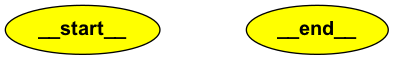

In [16]:
Image(graph.draw_png())

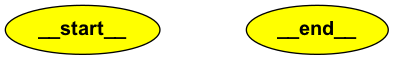

In [17]:
Image(StateGraph(dict).compile().get_graph().draw_png()) # stateはどの型でも動く

## Stateの更新

In [18]:
# ノードで実行する関数を定義
def func1(state):
    print("私はnode1です")
    print(f"stateは{state}")
    return 1

def func2(state):
    print("私はnode2です")
    print(f"stateは{state}")
    return 2

def func3(state):
    print("私はnode3です")
    print(f"stateは{state}")
    return 3

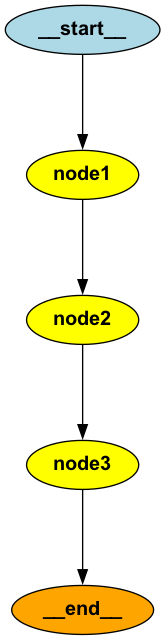

In [19]:
workflow = StateGraph(int) # Stateはint。ノードに紐づける関数がstateと同じintをreturnしている。
workflow.add_node("node1", func1)
workflow.add_node("node2", func2)
workflow.add_node("node3", func3)

workflow.add_edge("node1", "node2")
workflow.add_edge("node2", "node3")
workflow.add_edge("node3", END)

workflow.set_entry_point("node1")

graph = workflow.compile() # CompiledStateGraphなので、invokeできる
Image(graph.get_graph().draw_png())

In [20]:
graph.invoke(1) # 各ノードで状態が更新される

私はnode1です
stateは1
私はnode2です
stateは1
私はnode3です
stateは2


3

## Conditional Edgeを定義

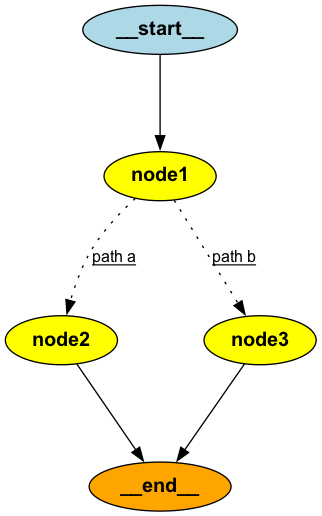

In [21]:
import random


def is_zero_or_one(state):
    if random.randint(0, 1) == 0:
        return "path a"
    else:
        return "path b"

workflow = StateGraph(int) # Stateはint。ノードに紐づける関数がstateと同じintをreturnしている。
workflow.add_node("node1", func1)
workflow.add_node("node2", func2)
workflow.add_node("node3", func3)

workflow.add_conditional_edges("node1", is_zero_or_one, {"path a": "node2", "path b": "node3"})
workflow.add_edge("node2", END)
workflow.add_edge("node3", END)


workflow.set_entry_point("node1")

graph = workflow.compile() # CompiledStateGraphなので、invokeできる
Image(graph.get_graph().draw_png())

In [22]:
graph.invoke(1)

私はnode1です
stateは1
私はnode3です
stateは1


3

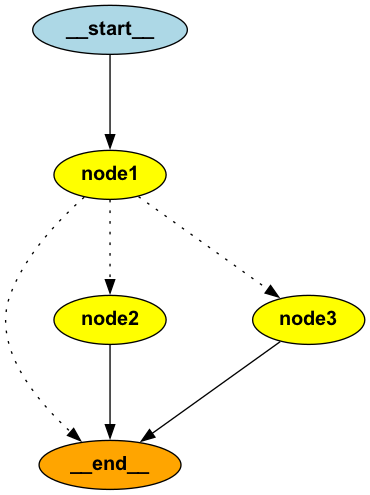

In [23]:
# 直接nodeを返すこともできる
def is_zero_or_one(state):
    if random.randint(0, 1) == 0:
        return "node2"
    else:
        return "node3"

workflow = StateGraph(int) # Stateはint。ノードに紐づける関数がstateと同じintをreturnしている。
workflow.add_node("node1", func1)
workflow.add_node("node2", func2)
workflow.add_node("node3", func3)

workflow.add_conditional_edges("node1", is_zero_or_one)
workflow.add_edge("node2", END)
workflow.add_edge("node3", END)


workflow.set_entry_point("node1")

graph = workflow.compile() # CompiledStateGraphなので、invokeできる
Image(graph.get_graph().draw_png())

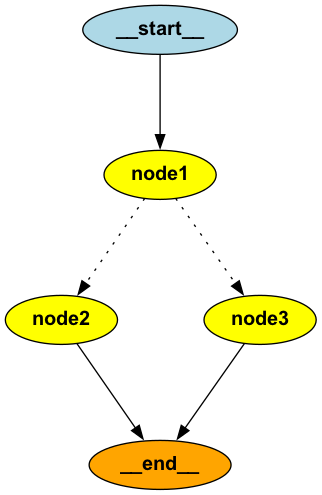

In [24]:
# 型ヒントを導入することで、ルーティングを正確に表現
from typing import Literal

def is_zero_or_one(state) -> Literal["node2", "node3"]: # Literalで返される値を指定
    if random.randint(0, 1) == 0:
        return "node2"
    else:
        return "node3"

workflow = StateGraph(int) # Stateはint。ノードに紐づける関数がstateと同じintをreturnしている。
workflow.add_node("node1", func1)
workflow.add_node("node2", func2)
workflow.add_node("node3", func3)

workflow.add_conditional_edges("node1", is_zero_or_one)
workflow.add_edge("node2", END)
workflow.add_edge("node3", END)


workflow.set_entry_point("node1")

graph = workflow.compile() # CompiledStateGraphなので、invokeできる
Image(graph.get_graph().draw_png())

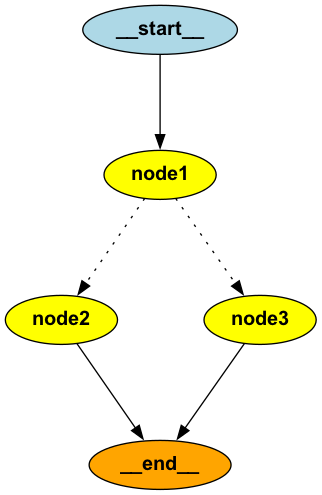

In [25]:
# Edgeが見えなくなってしまう例
import random
from typing import Literal


workflow = StateGraph(int)
workflow.add_node("node1", func1)
workflow.add_node("node2", func2)
workflow.add_node("node3", func3)

workflow.add_edge("node1", "node2") # 意図しないEdge
workflow.add_conditional_edges("node1", is_zero_or_one)
workflow.add_edge("node2", END)
workflow.add_edge("node3", END)


workflow.set_entry_point("node1")

graph = workflow.compile()
Image(graph.get_graph().draw_png()) # EdgeがConditional Edgeに上書きされて気づかない。実際にはEdgeは残っている。

## Multiple Edgesを定義

In [26]:
workflow = StateGraph(int)
workflow.add_node("node1", func1)
workflow.add_node("node2", func2)
workflow.add_node("node3", func3)

# node1からnode2とnode3に分岐させてみる
workflow.add_edge("node1", "node2")
workflow.add_edge("node1", "node3") # ここでエラーが発生

ValueError: Already found path for node 'node1'.
For multiple edges, use StateGraph with an annotated state key.

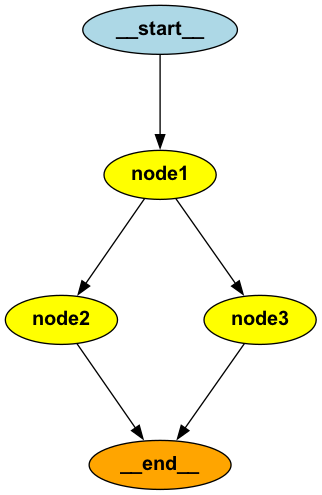

In [27]:
# multiple edgesを使うためにはannotated stateにする必要がある
from typing import Annotated

def reducer(a: int, b: int) -> int: # 2つの値を受け取って第2引数のみ返す
    return b

AnnotatedInt = Annotated[int, reducer] # Annotated intを利用

workflow = StateGraph(AnnotatedInt)
workflow.add_node("node1", func1)
workflow.add_node("node2", func2)
workflow.add_node("node3", func3)

workflow.add_edge("node1", "node2")
workflow.add_edge("node1", "node3")
workflow.add_edge("node2", END)
workflow.add_edge("node3", END)

workflow.set_entry_point("node1")

graph = workflow.compile()
Image(graph.get_graph().draw_png())

In [28]:
graph = workflow.compile() # Compileする事にnode2とnode3のどちらが先に実行されるかが変わる
graph.invoke(1)

私はnode1です
stateは1
私はnode3です
stateは1
私はnode2です
stateは1


3

In [29]:
# 定義済みの関数を利用
import operator

operator.add(1, 2) # LangGraphでよく使われるreducer

3

In [30]:
operator.add([1, 2], [3])

[1, 2, 3]

In [31]:
AnnotatedInt = Annotated[int, operator.add]

workflow = StateGraph(AnnotatedInt)
workflow.add_node("node1", func1)
workflow.add_node("node2", func2)
workflow.add_node("node3", func3)

workflow.add_edge("node1", "node2")
workflow.add_edge("node1", "node3")
workflow.add_edge("node2", END)
workflow.add_edge("node3", END)

workflow.set_entry_point("node1")

graph = workflow.compile()

In [32]:
graph.invoke(1)

私はnode1です
stateは1
私はnode2です
stateは2
私はnode3です
stateは2


7

In [33]:
AnnotatedList = Annotated[list, operator.add]

workflow = StateGraph(AnnotatedList)
workflow.add_node("node1", lambda x: [1])
workflow.add_node("node2", lambda x: [2])
workflow.add_node("node3", lambda x: [3])

workflow.add_edge("node1", "node2")
workflow.add_edge("node1", "node3")
workflow.add_edge("node2", END)
workflow.add_edge("node3", END)

workflow.set_entry_point("node1")

In [34]:
graph = workflow.compile()
graph.invoke([0])

[0, 1, 2, 3]

In [35]:
from typing import TypedDict

class AnnotatedTypedDict(TypedDict):
    messages: Annotated[list, operator.add]

In [36]:
workflow = StateGraph(AnnotatedTypedDict)
workflow.add_node("node1", lambda x: {"messages": ["I'm node 1."]})
workflow.add_node("node2", lambda x: {"messages": ["I'm node 2."]})
workflow.add_node("node3", lambda x: {"messages": ["I'm node 3."]})

workflow.add_edge("node1", "node2")
workflow.add_edge("node1", "node3")
workflow.add_edge("node2", END)
workflow.add_edge("node3", END)

workflow.set_entry_point("node1")

graph = workflow.compile()
graph.invoke({"messages": ["start"]})

{'messages': ['start', "I'm node 1.", "I'm node 2.", "I'm node 3."]}